![A soccer pitch for an international match.](soccer-pitch.jpg)

You're working as a sports journalist at a major online sports media company, specializing in soccer analysis and reporting. You've been watching both men's and women's international soccer matches for a number of years, and your gut instinct tells you that more goals are scored in women's international football matches than men's. This would make an interesting investigative article that your subscribers are bound to love, but you'll need to perform a valid statistical hypothesis test to be sure!

While scoping this project, you acknowledge that the sport has changed a lot over the years, and performances likely vary a lot depending on the tournament, so you decide to limit the data used in the analysis to only official `FIFA World Cup` matches (not including qualifiers) since `2002-01-01`.

You create two datasets containing the results of every official men's and women's international football match since the 19th century, which you scraped from a reliable online source. This data is stored in two CSV files: `women_results.csv` and `men_results.csv`.

The question you are trying to determine the answer to is:

> Are more goals scored in women's international soccer matches than men's?

You assume a **10% significance level**, and use the following null and alternative hypotheses:

$H_0$ : The mean number of goals scored in women's international soccer matches is the same as men's.

$H_A$ : The mean number of goals scored in women's international soccer matches is greater than men's.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4884 entries, 0 to 4883
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4884 non-null   int64 
 1   date        4884 non-null   object
 2   home_team   4884 non-null   object
 3   away_team   4884 non-null   object
 4   home_score  4884 non-null   int64 
 5   away_score  4884 non-null   int64 
 6   tournament  4884 non-null   object
dtypes: int64(3), object(4)
memory usage: 267.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44353 entries, 0 to 44352
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  44353 non-null  int64 
 1   date        44353 non-null  object
 2   home_team   44353 non-null  object
 3   away_team   44353 non-null  object
 4   home_score  44353 non-null  int64 
 5   away_score  44353 non-null  int64 
 6   tournament  44353 non-null  object
dtypes: int64(

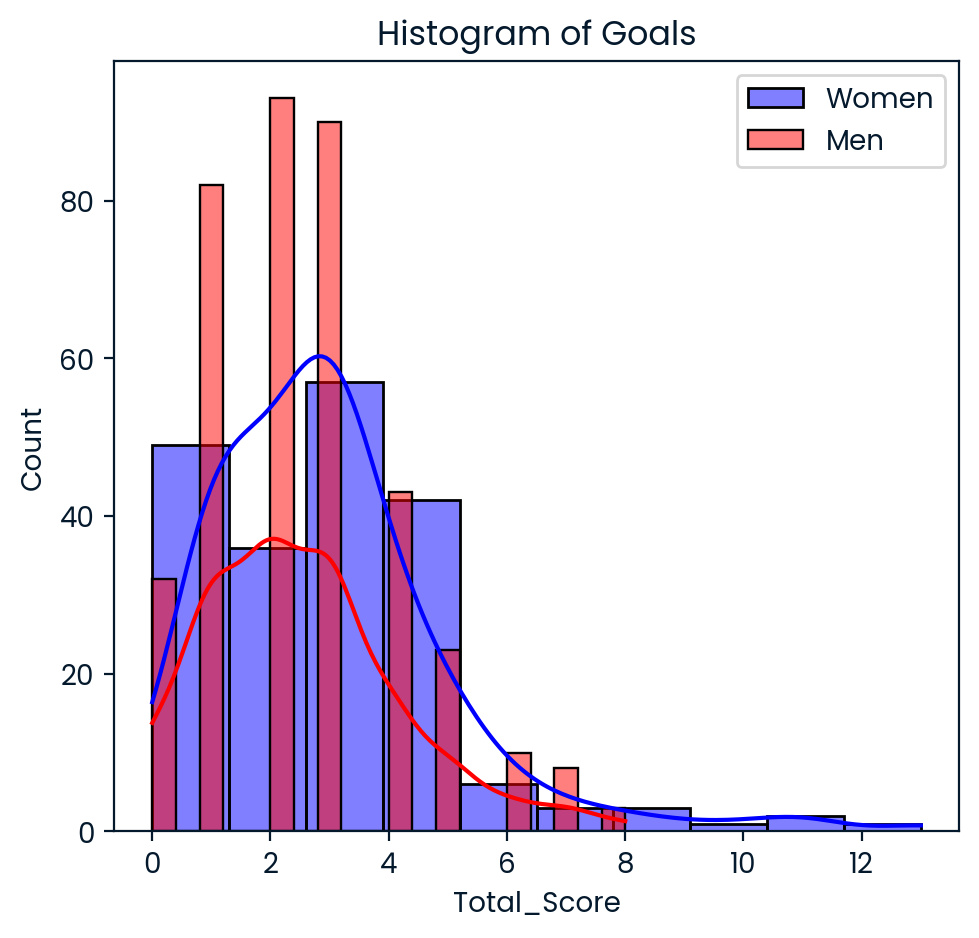

In [49]:
# Start code here!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, probplot, mannwhitneyu 
import pingouin as pg

women_results = pd.read_csv('women_results.csv')
men_results = pd.read_csv('men_results.csv')

# Column names and data type
women_results.info()

# Any Missing values
women_results.isna().sum()

# Convert date column from object to datetime 
women_results['date'] = pd.to_datetime(women_results['date'])

# Values for tournament
women_results['tournament'].unique()

# Total Goals Scored by women
women_results['Total_Score'] = women_results['home_score'] + women_results['away_score']

# Filter for FIFA World Cup and date beyond 2002-01-01
filter_criteria = ((women_results['tournament'] == 'FIFA World Cup') 
                   & (women_results['date'] > '2002-01-01'))

# Use .loc and the filter to select for goals
women_goals = women_results.loc[filter_criteria, 'Total_Score']


# Column names and data type
men_results.info()

# Any Missing values
men_results.isna().sum()

# Convert date column from object to datetime 
men_results['date'] = pd.to_datetime(men_results['date'])

# Total Goals Scored by women
men_results['Total_Score'] = men_results['home_score'] + men_results['away_score']

# Filter for FIFA World Cup and date beyond 2002-01-01
filter_criteria1 = ((men_results['tournament'] == 'FIFA World Cup') 
                   & (men_results['date'] > '2002-01-01'))

# Use .loc and the filter to select for goals
men_goals = men_results.loc[filter_criteria1, 'Total_Score']

# Set significance level
alpha = 0.10

# --- 1. Visualization Methods of Checking for Normality ---

# Histogram
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(women_goals, kde=True, bins=10, color="blue", label="Women")
sns.histplot(men_goals, kde=True, bins=20, color="red", label="Men")
plt.legend()
plt.title("Histogram of Goals")

# --- 2. Statistical Normality Tests ---

# Shapiro-Wilk Test
shapiro_women = shapiro(women_goals)
shapiro_men = shapiro(men_goals)

print(f"Shapiro-Wilk Test for Women's Goals: p = {shapiro_women.pvalue:.5f}")
print(f"Shapiro-Wilk Test for Men's Goals: p = {shapiro_men.pvalue:.5f}")

# Normality Decision
if shapiro_women.pvalue > alpha:
    print("Women's goals follow a normal distribution.")
else:
    print("Women's goals do NOT follow a normal distribution, hence use Wilcoxon-Mann-Whitney test.")

if shapiro_men.pvalue > alpha:
    print("Men's goals follow a normal distribution.")
else:
    print("Men's goals do NOT follow a normal distribution, hence use Wilcoxon-Mann-Whitney test.")
    

# --- Hypothesis Test Using Wilcoxon-Mann-Whitney test ---
u_stat, p_val = mannwhitneyu(women_goals, men_goals, alternative='greater')

# Alternative

# Filter the data for the time range and tournament
men_filter = men_results[(men_results["date"] > "2002-01-01") & (men_results["tournament"].isin(["FIFA World Cup"]))]
women_filter = women_results[(women_results["date"] > "2002-01-01") & (women_results["tournament"].isin(["FIFA World Cup"]))]

# Create group and goals_scored columns
men_filter["group"] = "men"
women_filter["group"] = "women"

# Combine women's and men's data and calculate goals scored in each match
both = pd.concat([women_filter, men_filter], axis=0, ignore_index=True)

# Transform the data for the pingouin Mann-Whitney U t-test/Wilcoxon-Mann-Whitney test
both_subset = both[["Total_Score", "group"]]
both_subset_wide = both_subset.pivot(columns="group", values="Total_Score")

# Perform right-tailed Wilcoxon-Mann-Whitney test with pingouin
results_pg = pg.mwu(x=both_subset_wide["women"],
                          y=both_subset_wide["men"],
                          alternative="greater")

# Extract p-value as a float
p_val1 = results_pg["p-val"].values[0]

# Determine the test result
result = "reject" if p_val1 < alpha else "fail to reject"

# Store in dictionary
result_dict = {"p_val": p_val1, "result": result}

print(result_dict)  # Final dictionary output